In [1]:
import glob

from imutils import contours
import matplotlib.pyplot as plt 
import numpy as np
import imutils
import cv2
import PIL

In [2]:
def plot(img, cmap=None):
    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.imshow(img, cmap=cmap)
    plt.show()

def plot_seg(path):
    fns = glob.glob(path + '/*')
    fns.sort()
    for line, fn in enumerate(fns):
        img = cv2.imread(fn)
        print("line:", line+1)
        plot(img, cmap='gray')

Load image and resize to fix size of (3000, 600)

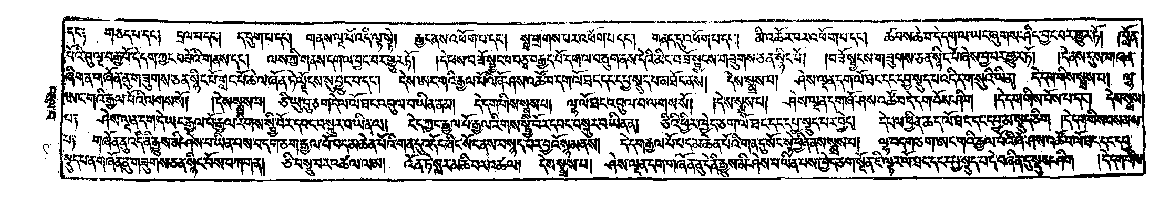

(332, 2123, 3)

In [435]:
img = cv2.imread('images/page-008.png')
plot(img); img.shape

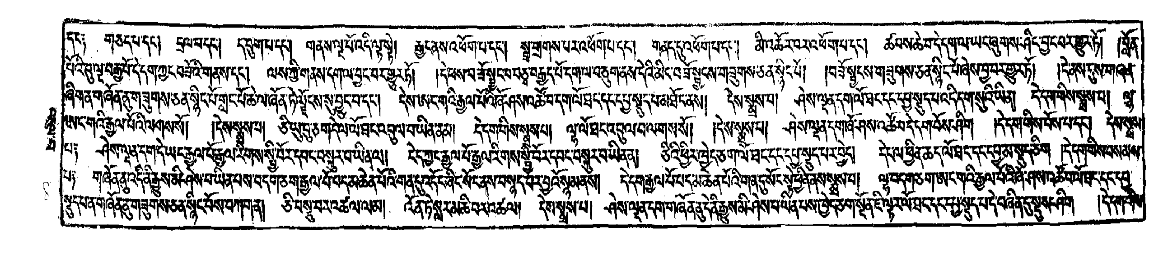

(600, 3000, 3)

In [436]:
img = cv2.resize(img, (3000, 600))
plot(img); img.shape

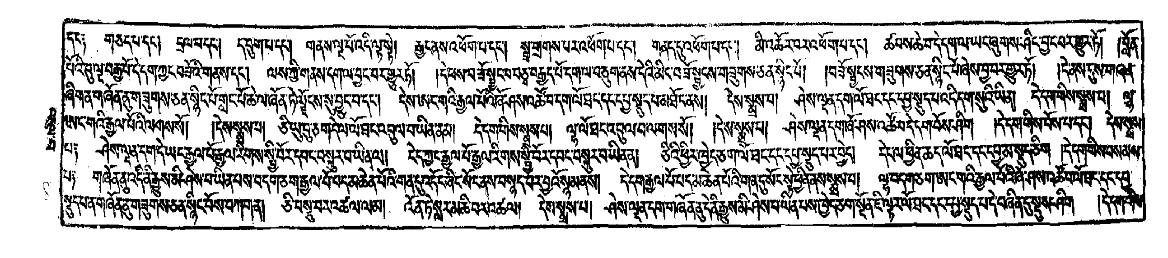

(600, 3000)

In [437]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plot(gray, cmap='gray'); gray.shape

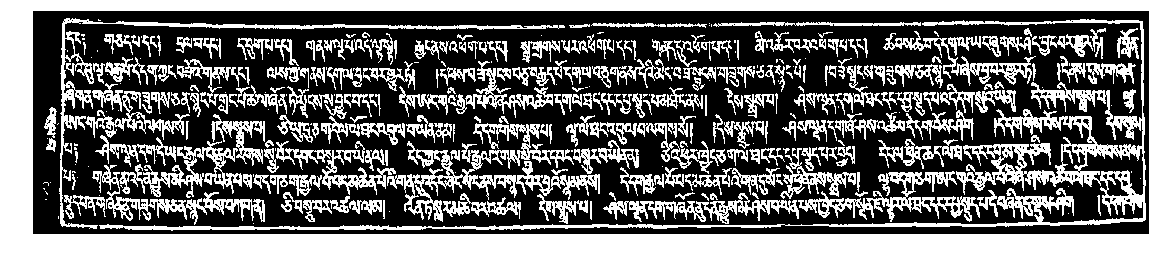

In [438]:
ret,thresh = cv2.threshold(gray,150,255,cv2.THRESH_BINARY_INV)
plot(thresh, cmap='gray')

# 3 solutions
1. Opening morphological operation
1. findContour and Ploygon Approximation
1. Probabilistic hough line transformation

## 1. Opening morphological operation

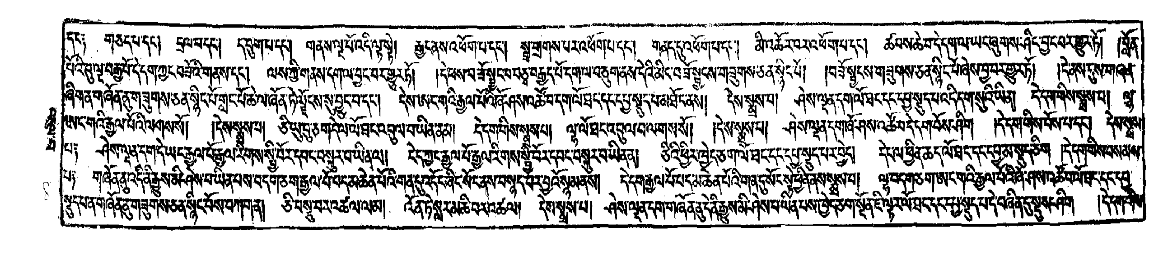

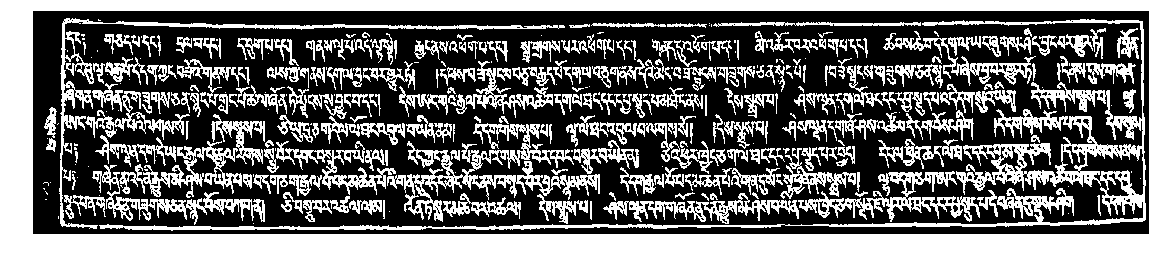

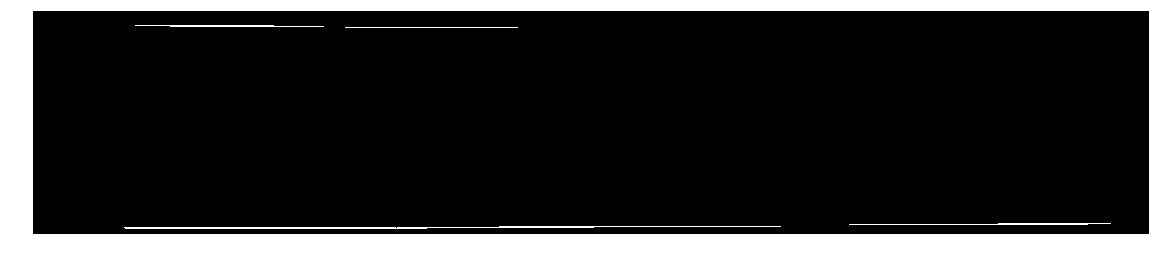

In [439]:
kernel = np.ones((1, 300), np.uint8)
opening_h = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
plot(img)
plot(thresh, cmap='gray')
plot(opening_h, cmap='gray');

Fill the broken horizontal line

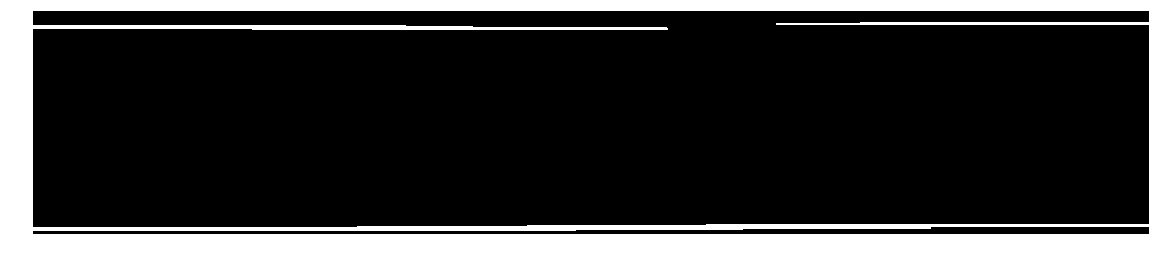

In [440]:
kernel = np.ones((2, 200), np.uint8)  # note this is a horizontal kernel
d_im = cv2.dilate(opening_h, kernel, iterations=5)
e_im = cv2.erode(d_im, kernel, iterations=1)
plot(e_im, cmap='gray')

In [441]:
opening_h = e_im

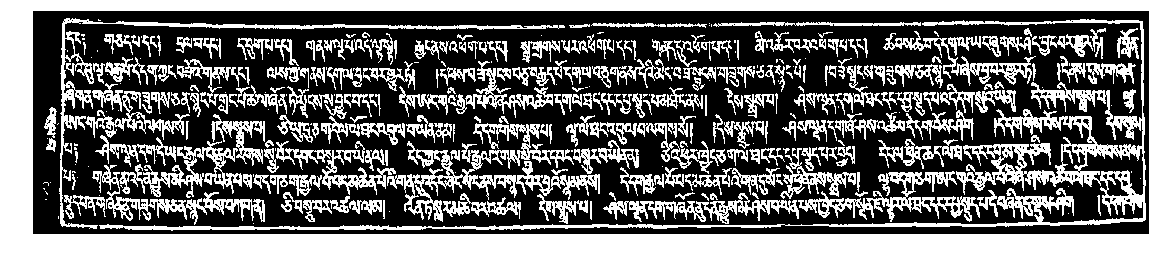

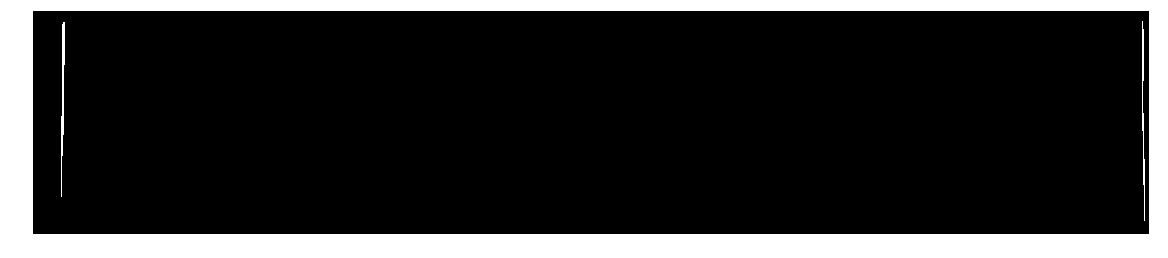

In [442]:
kernel = np.ones((100, 1), np.uint8)
opening_v = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
plot(thresh, cmap='gray')
plot(opening_v, cmap='gray');

Fix the borken vertical lines

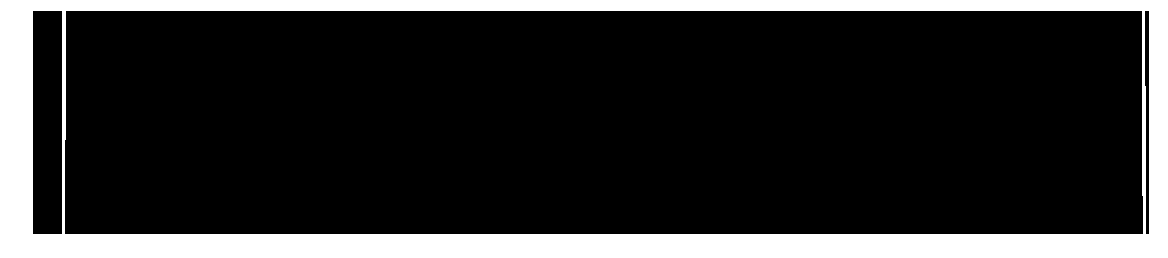

In [443]:
kernel = np.ones((200, 2), np.uint8)  # note this is a horizontal kernel
d_im = cv2.dilate(opening_v, kernel, iterations=3)
e_im = cv2.erode(d_im, kernel, iterations=1)
plot(e_im, cmap='gray')

In [444]:
opening_v = e_im

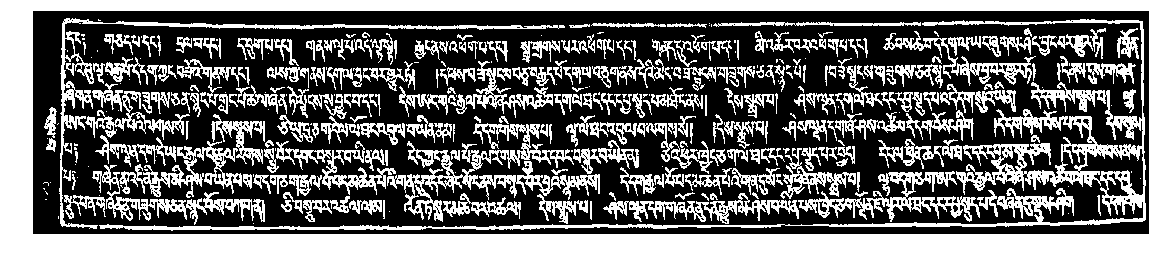

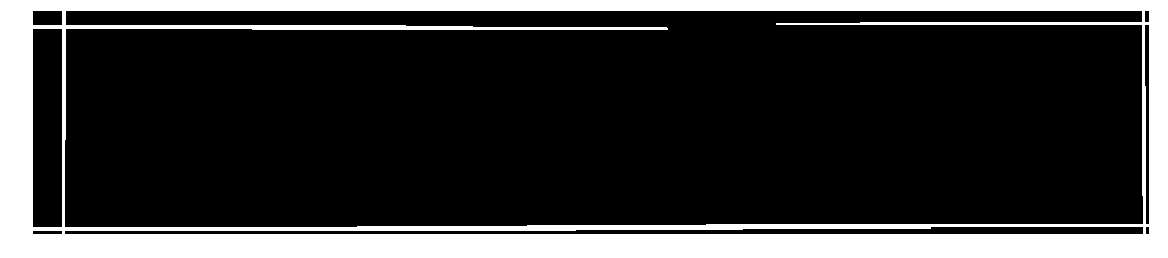

In [445]:
opening = opening_h + opening_v
plot(thresh, cmap='gray')
plot(opening, cmap='gray')

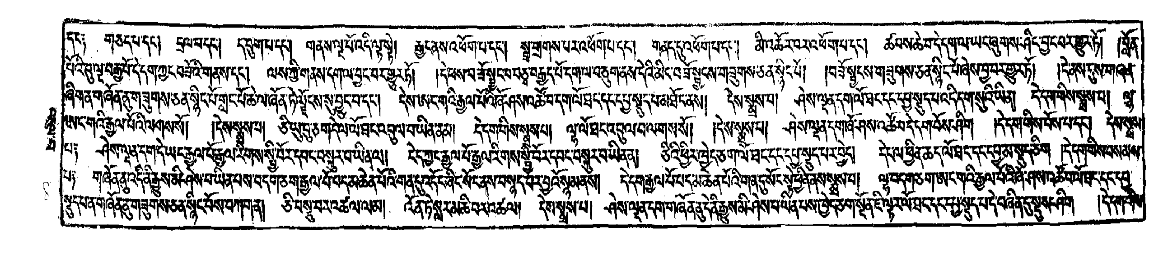

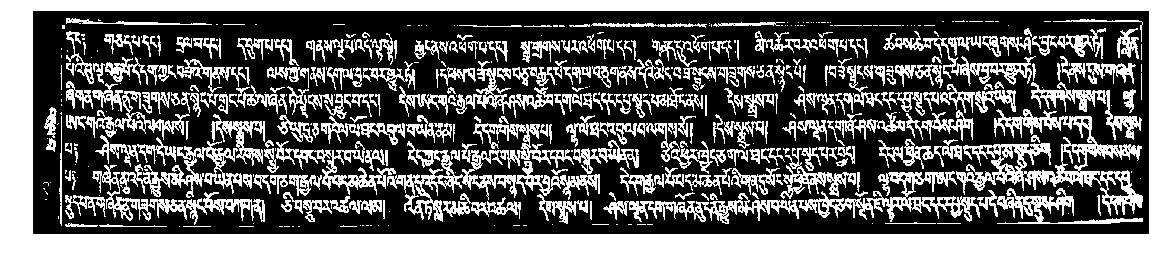

In [446]:
mask = thresh == opening
thresh[mask] = 0
plot(img)
plot(thresh, cmap='gray')

remove noise in vertical border -> Used `horizontal kernel` (making verticle border pixels noise)

Original


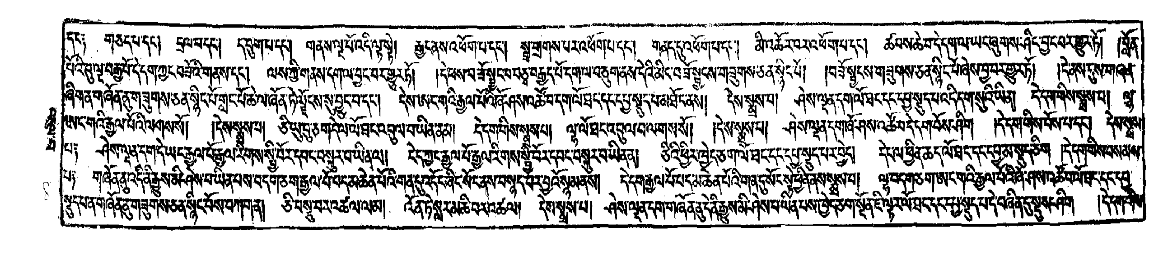

Input


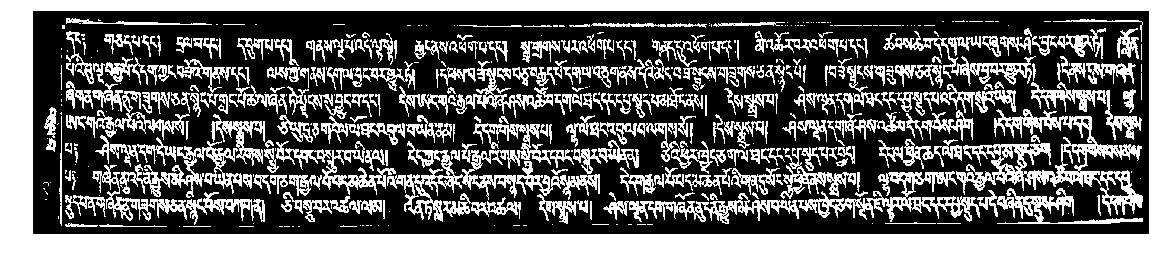

Output


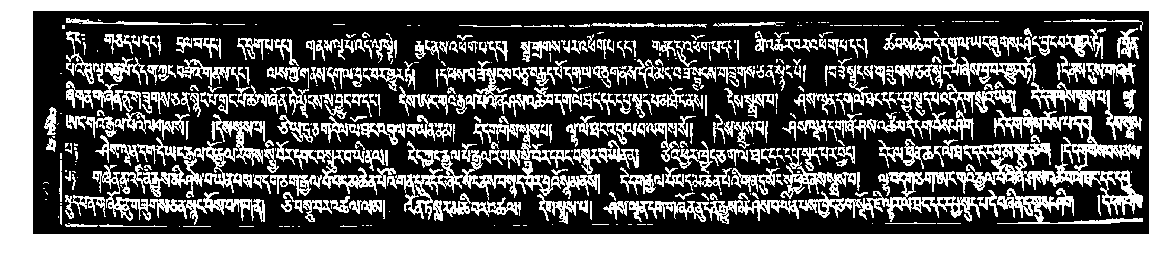

In [447]:
kernel = np.ones((1, 3), np.uint8) 
cleaned_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
print('Original')
plot(img)
print('Input')
plot(thresh, cmap='gray')
print('Output')
plot(cleaned_vertical, cmap='gray');

remove noise in horizontal border -> Used `Vertical Kernel` (making horizontal border pixels a noise)

Orginal


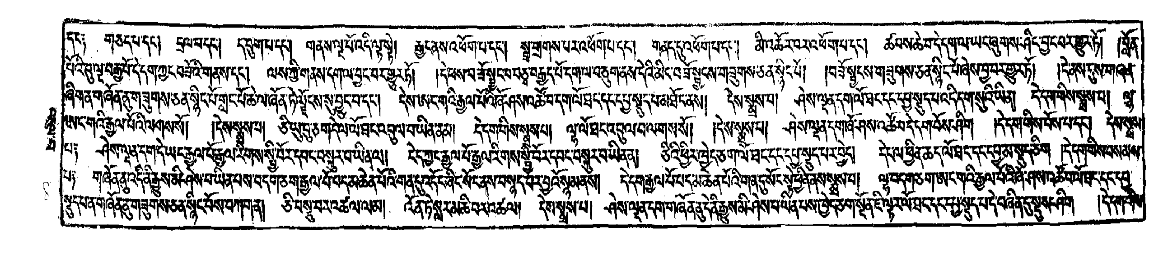

Input


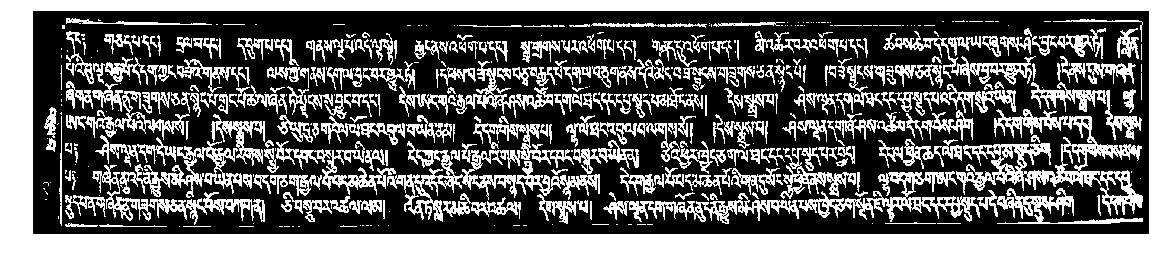

Output


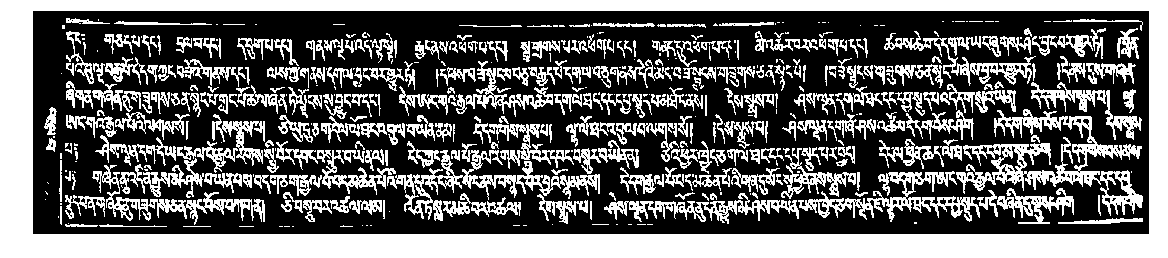

In [448]:
kernel = np.ones((3, 1), np.uint8)
cleaned_horizontal= cv2.morphologyEx(cleaned_vertical, cv2.MORPH_OPEN, kernel)
print('Orginal')
plot(img)
print('Input')
plot(thresh, cmap='gray')
print('Output')
plot(cleaned_horizontal, cmap='gray');

Inverse the image and save

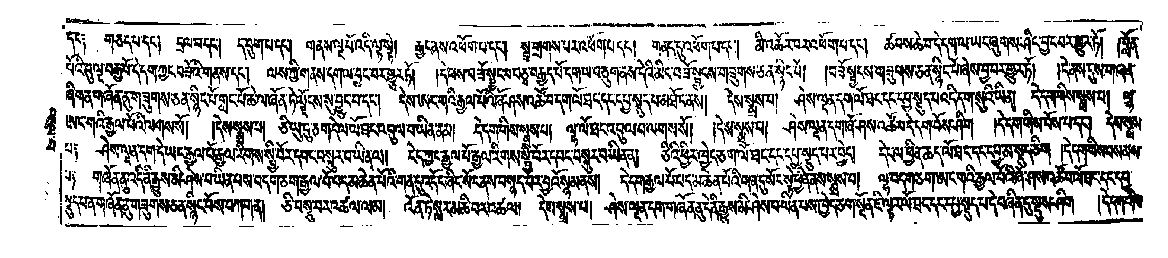

In [449]:
final = cv2.bitwise_not(cleaned_horizontal)
plot(final, cmap='gray')

In [450]:
cv2.imwrite('../images/page-006-wob.png', final)

False

pageseg result

In [451]:
plot_seg('../images/page-006-wob')

## 3. Probabilistic hough line transformation
start from output of opening

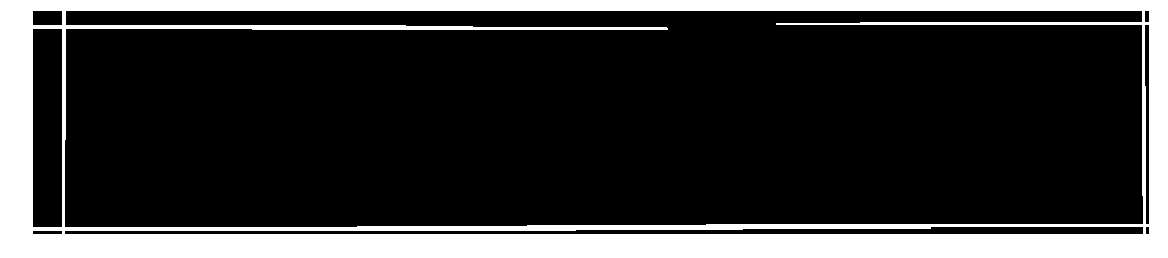

In [452]:
plot(opening, cmap='gray')

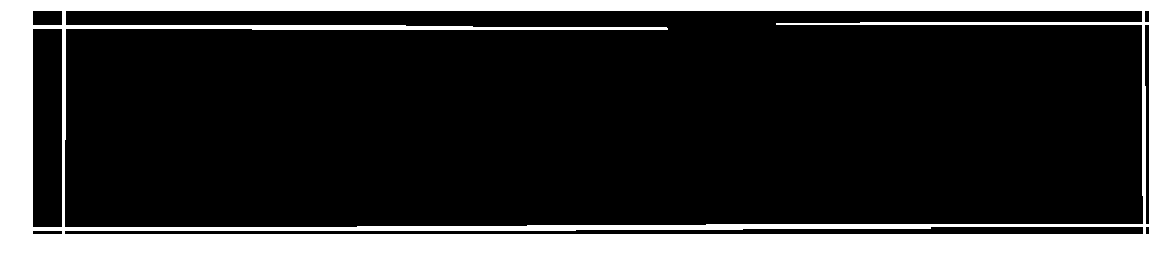

In [453]:
ret,thresh2 = cv2.threshold(opening,127,255,cv2.THRESH_BINARY)
plot(thresh2, cmap='gray')

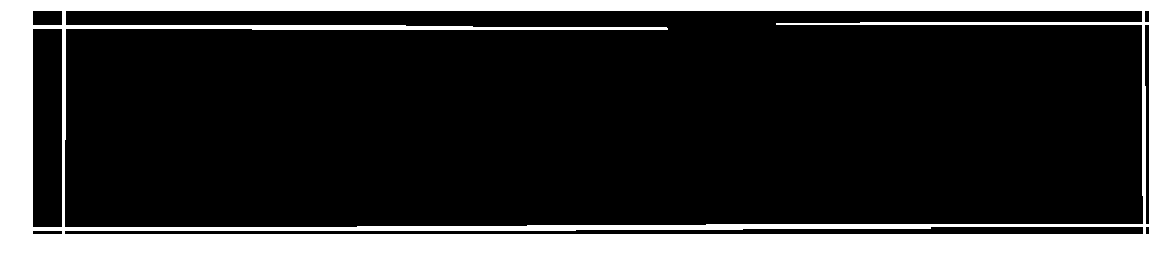

In [454]:
gray = cv2.bilateralFilter(thresh2, 11, 17, 17)
plot(gray, cmap='gray')

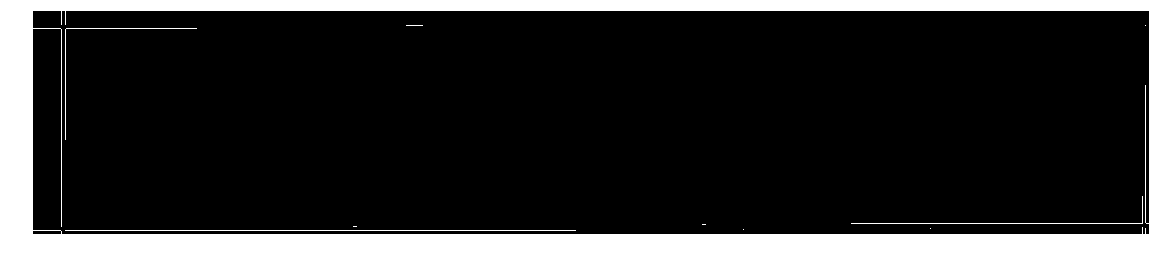

In [455]:
edged = cv2.Canny(gray, 10, 100)
plot(edged, cmap='gray')

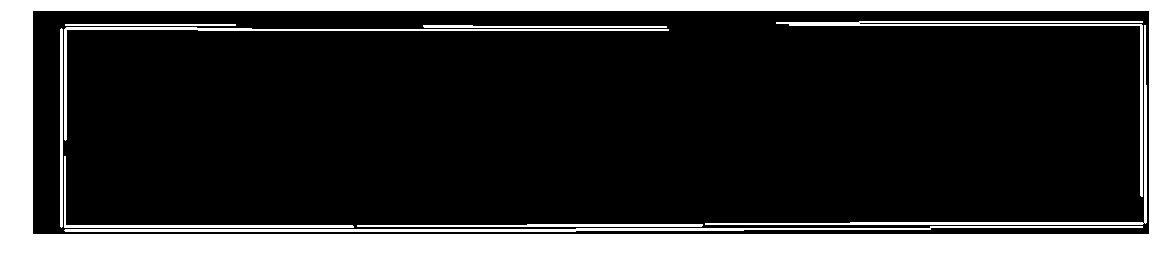

PHough Transformation


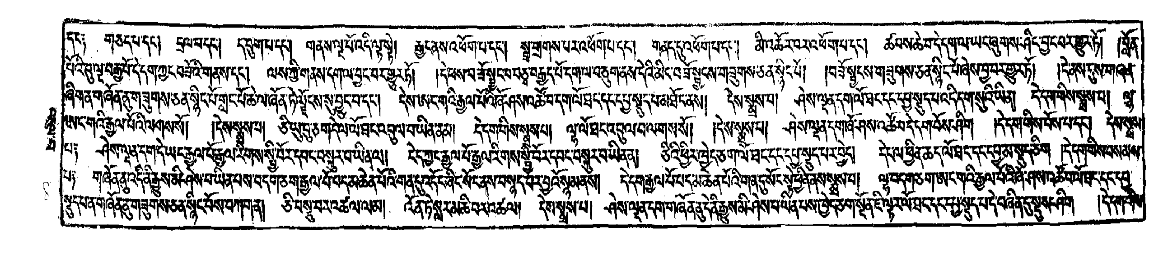

Opening


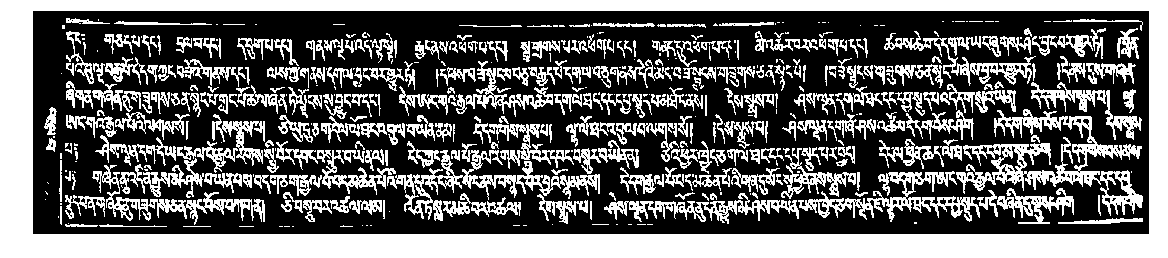

In [465]:
sol2_img = img.copy()
canvas = canvas = np.zeros(img.shape, np.uint8)

minLineLength = 5000
maxLineGap = 100
lines = cv2.HoughLinesP(edged.copy(),1,np.pi/180,100,minLineLength,maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(canvas,(x1,y1),(x2,y2),(255,255,255), 5)
#         cv2.line(sol2_img,(x1,y1),(x2,y2),(255,255,255), 5)

plot(canvas, cmap='gray')
print('PHough Transformation')
plot(sol2_img)
print('Opening')
plot(cleaned_horizontal,cmap='gray')

## Remove the border text

###  Algorithm

In [457]:
## check whether line is horizontal or vertical -> assumtion: all line are vertically or horizontally straight line.
hr_offset_ref = 100
vt_offset_ref = 500

ref = {'left': 250,   
       'right': 2750, 
       'top': 100,  
       'bottom': 500}

def is_horizontal(line):
    x1, y1, x2, y2 = line
    return y1 == y2 and x1 != x2

def is_left(line, ref):
    x1, y1, x2, y2 = line
    return x1 < ref['left']

def is_top(line, ref):
    x1, y1, x2, y2 = line
    return y1 < ref['top']

def find_position(line, ref):
    if is_horizontal(line):
        print('Horizontal', end=' ')
        if is_top(line, ref):
            print('Top')
        else:
            print('Bottom')
    else:
        print('Vertical', end=' ')
        if is_left(line, ref):
            print('Left')
        else:
            print('Right')

Reference lines


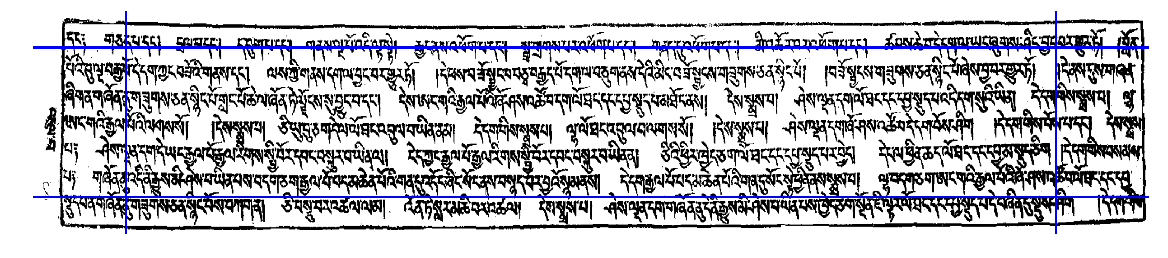

In [458]:
# plot reference lines
ref_line = [[ref['left'], 0, ref['left'], 600],
            [ref['right'], 0, ref['right'], 600],
            [0, ref['top'], 3000, ref['top']],
            [0, ref['bottom'], 3000, ref['bottom']]]

ref_img = img.copy()
for x1,y1,x2,y2 in ref_line:
        cv2.line(ref_img,(x1,y1),(x2,y2),(0,0,255), 5)
print('Reference lines')
plot(ref_img)

Test

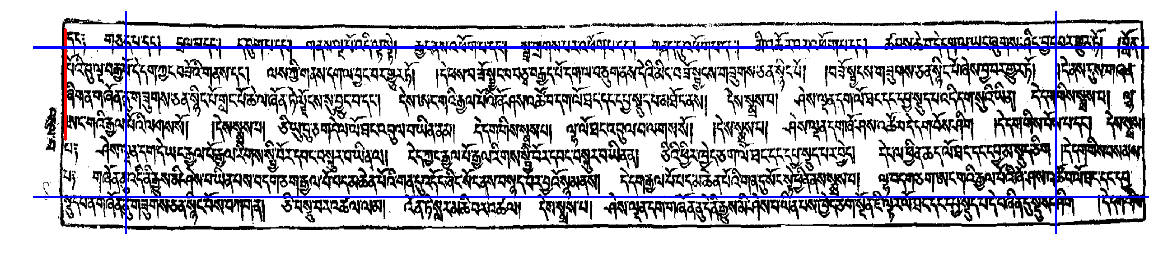

Line Position: Vertical Left


In [459]:
border_img = img.copy()

idx = 17  # line to test

for x1,y1,x2,y2 in lines[idx]:
    cv2.line(border_img,(x1,y1),(x2,y2),(255,0,0), 5)

for x1,y1,x2,y2 in ref_line:
    cv2.line(border_img,(x1,y1),(x2,y2),(0,0,255), 5)

plot(border_img)
print('Line Position:', end=' '); find_position(lines[idx][0], ref)

In [460]:
def find_rectangle(line, img):
    x1, y1, x2, y2 = line
    height, width, _ = img.shape
    rect = []
    
    if is_horizontal(line):
        # extends the vertical line till end according to the reference
        if x2 < ref['left']:
            x2 = 0
            line[2] = 0
        if x1 > ref['right']:
            x1 = width
            line[0] = width
        rect.append(line)
        
        if is_top(line, ref):
            rect.append([x1, 0, x2, 0]) 
        else:
            rect.append([x1, height, x2, height])
    else:
        # extends the vertical line till end according to the reference
        if y2 < ref['top']:
            y2 = 0
            line[3] = 0
        if y1 > ref['bottom']:
            y1 = height
            line[1] = height
        rect.append(line)
        
        if is_left(line, ref):
             rect.append([0, y1, 0, y2]) 
        else:
            rect.append([width, y1, width, y2])
    return rect

[array([ 87, 348,  87,   0], dtype=int32), [0, 348, 0, 0]]
(0, 0) (87, 348)


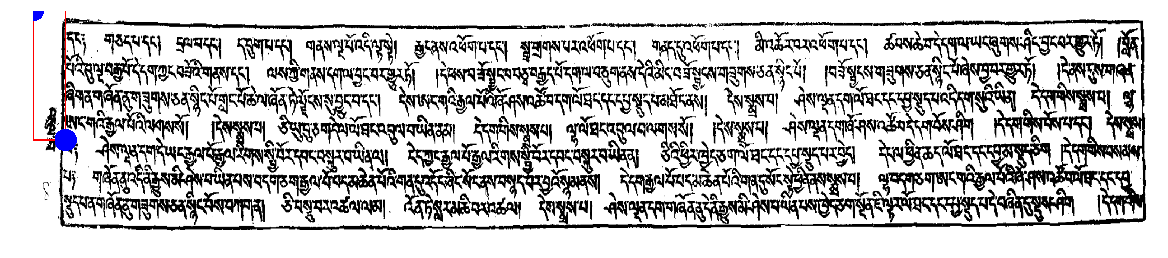

In [462]:
rect = find_rectangle(lines[idx][0], border_img)

print(rect)

# Plot rectangle
rect_img = img.copy()
tl = tuple(rect[1][2:])
br = tuple(rect[0][:2])
print(tl, br)
cv2.rectangle(rect_img, tl, br, (255, 0, 0), 3)
cv2.circle(rect_img,tl, 30, (0,0,255), -1)
cv2.circle(rect_img,br, 30, (0,0,255), -1)
plot(rect_img)

## Implement Border removal to whole image

In [463]:
def remove_border_text(line, img):
    rect = find_rectangle(line, img)
    tl = tuple(rect[1][:2])
    br = tuple(rect[0][2:])
    cv2.rectangle(img, tl, br, (255, 0, 0), -1)

Original: 


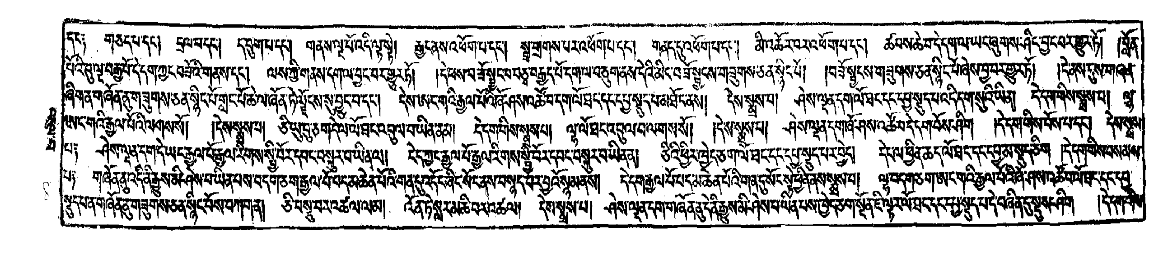

PHough Transformation


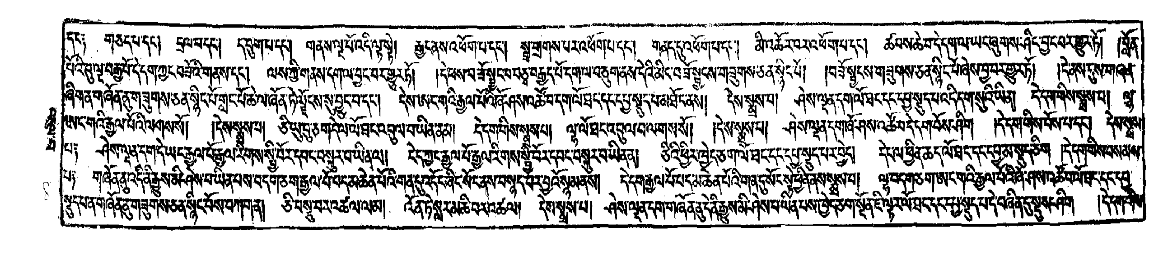

Border Text Removal:


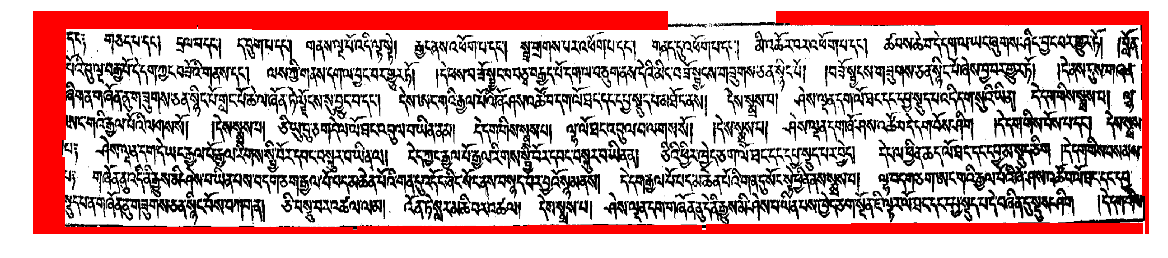

In [464]:
print('Original: ')
plot(img)
print('PHough Transformation')
plot(sol2_img)

for line in lines:
    remove_border_text(line[0], sol2_img)
        
print('Border Text Removal:')
plot(sol2_img)

Check segmentation output

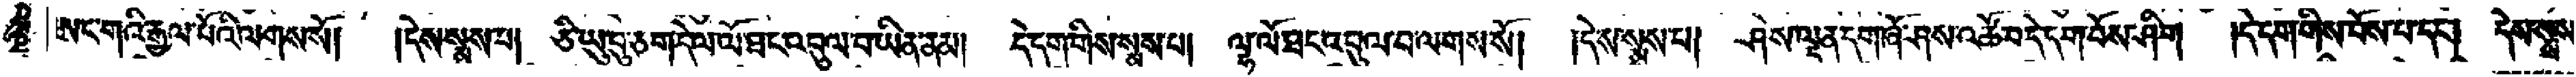

In [468]:
seg_no_br = PIL.Image.open('../output/volumes/vol-1-bake/page-008/010004.bin.png'); seg_no_br

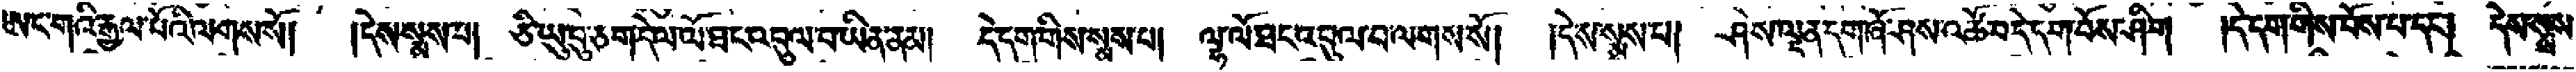

In [470]:
seg_with_br = PIL.Image.open('../output/volumes/vol-1/page-008/010004.bin.png'); seg_with_br

In [88]:
'''
python pageseg.py --maxcolseps 0 --usegauss -q images/page-006-wob-sol2.png

usage: pageseg.py [-n] [--minscale MINSCALE] [--maxlines MAXLINES]
                  [--scale SCALE] [--hscale HSCALE] [--vscale VSCALE]
                  [--threshold THRESHOLD] [--noise NOISE] [--usegauss]
                  [--maxseps MAXSEPS] [--sepwiden SEPWIDEN]
                  [--maxcolseps MAXCOLSEPS] [--csminheight CSMINHEIGHT]
                  [--gray] [-p PAD] [-e EXPAND] [-q] [-Q PARALLEL] [-d] [-h]
                  files [files ...]

positional arguments:
  files

error checking:
  -n, --nocheck         disable error checking on inputs
  --minscale MINSCALE   minimum scale permitted, default: 12.0
  --maxlines MAXLINES   maximum # lines permitted, default: 300

scale parameters:
  --scale SCALE         the basic scale of the document (roughly, xheight)
                        0=automatic, default: 0.0
  --hscale HSCALE       non-standard scaling of horizontal parameters,
                        default: 1.0
  --vscale VSCALE       non-standard scaling of vertical parameters, default:
                        1.0

line parameters:
  --threshold THRESHOLD
                        baseline threshold, default: 0.2
  --noise NOISE         noise threshold for removing small components from
                        lines, default: 8
  --usegauss            use gaussian instead of uniform, default: False

column parameters:
  --maxseps MAXSEPS     maximum black column separators, default: 0
  --sepwiden SEPWIDEN   widen black separators (to account for warping),
                        default: 10
  --maxcolseps MAXCOLSEPS
                        maximum # whitespace column separators, default: 3
  --csminheight CSMINHEIGHT
                        minimum column height (units=scale), default: 10

output parameters:
  --gray                output grayscale lines as well, which are extracted
                        from the grayscale version of the pages, default:
                        False
  -p PAD, --pad PAD     padding for extracted lines, default: 3
  -e EXPAND, --expand EXPAND
                        expand mask for grayscale extraction, default: 3

others:
  -q, --quiet           be less verbose, default: False
  -Q PARALLEL, --parallel PARALLEL
                        number of CPUs to use
  -d, --debug
  -h, --help            show this help message and exit
''';

# Theory

## morphological operation:
- Morphological transformations are some simple operations based on the image shape
- It is normally performed on binary images
- It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation

### 1. Erosion
- The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object (Always try to keep foreground in white).
- A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).

- all the pixels near boundary will be discarded depending upon the size of kernel. 
- It is useful for removing small white noises
- Erosion does dialation for inverse binary image (bg is wihte and morphology is black)

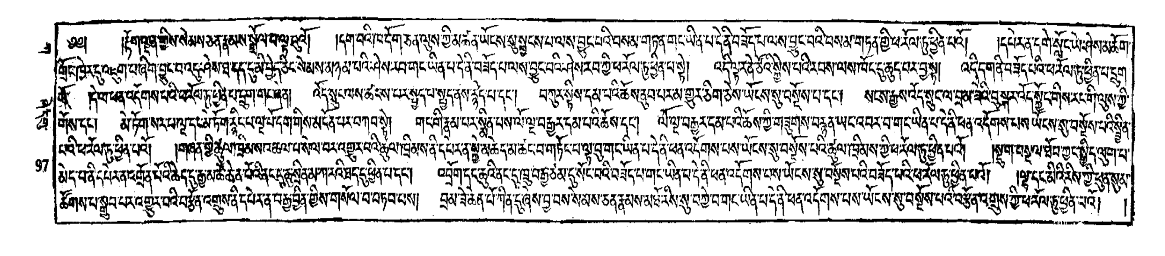

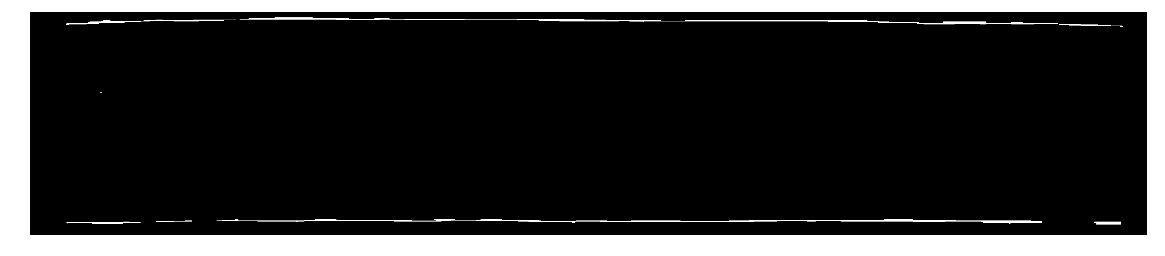

In [141]:
kernel = np.ones((1, 65), np.uint8)
erosion = cv2.erode(thresh, kernel, iterations = 1)
plot(img)
plot(erosion, cmap='gray')

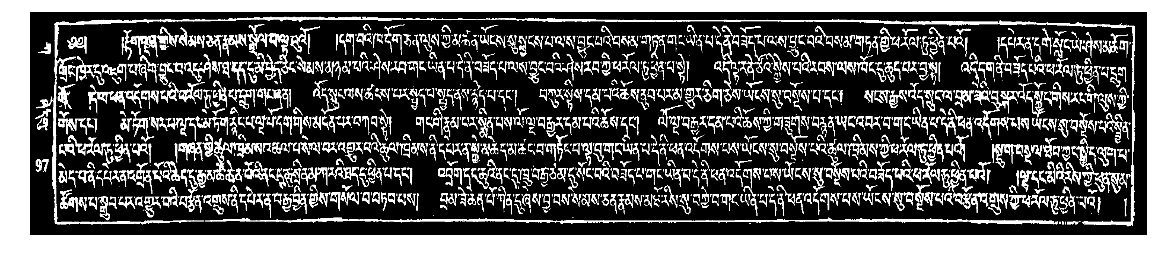

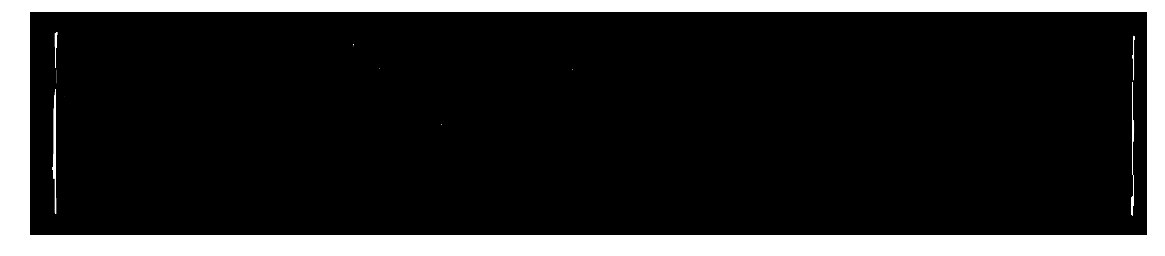

In [142]:
kernel = np.ones((55, 1), np.uint8)
erosion = cv2.erode(thresh, kernel, iterations = 1)
plot(thresh, cmap='gray')
plot(erosion, cmap='gray')

### 2. Dilation
- It is just opposite of erosion
- a pixel element is '1' if atleast one pixel under the kernel is '1'.
- So it increases the white region in the image or size of foreground object increases
- Normally, in cases like noise removal, erosion is followed by dilation
    - Because erosion removes white noises, but it also shrinks our object. So we dilate it
    - Since noise is gone, they won't come back, but our object area increases
- It is also useful in joining broken parts of an object. 

Dialation on Theshold image

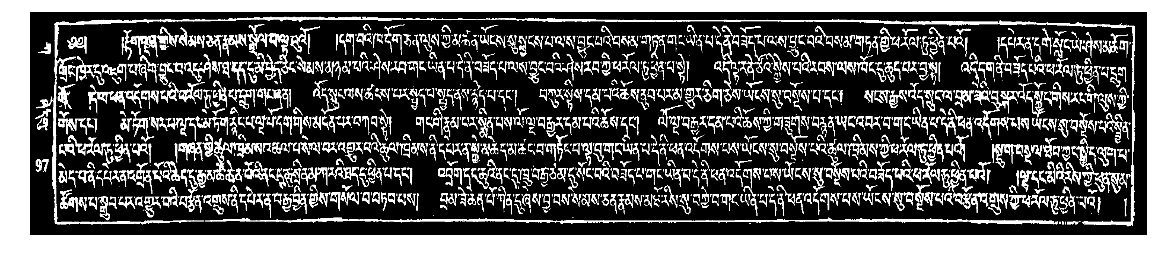

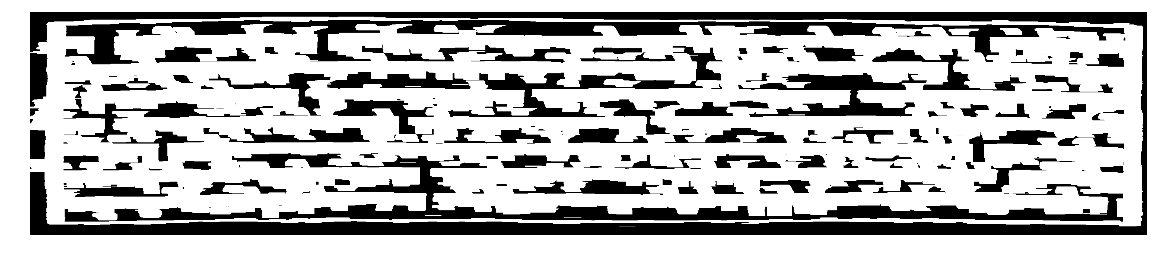

In [143]:
kernel = np.ones((1, 15), np.uint8)
dilation = cv2.dilate(thresh,kernel,iterations = 3)
plot(thresh, cmap='gray');
plot(dilation, cmap='gray')

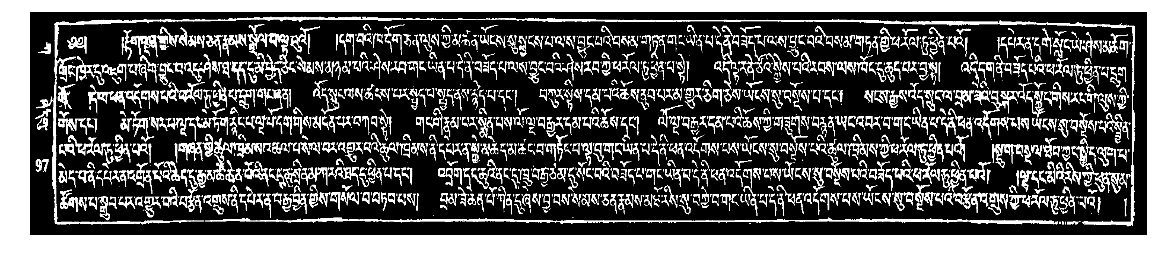

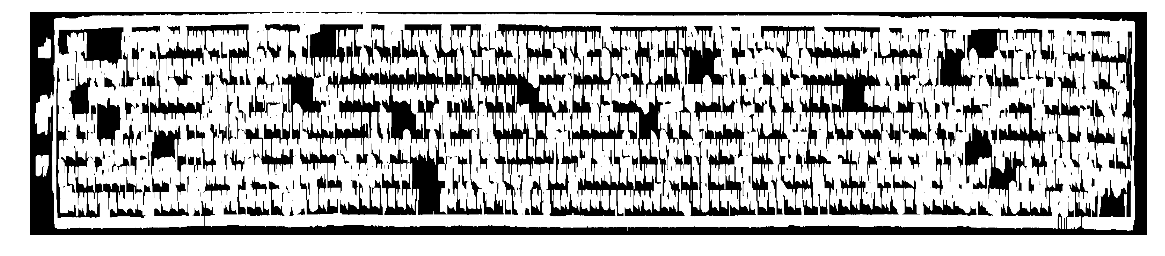

In [144]:
kernel = np.ones((9, 1), np.uint8)
dilation = cv2.dilate(thresh,kernel,iterations = 3)
plot(thresh, cmap='gray');
plot(dilation, cmap='gray')

Dialation after Erosion

### 3. Opening
- Opening is just another name of erosion followed by dilation
- It is useful in removing noise

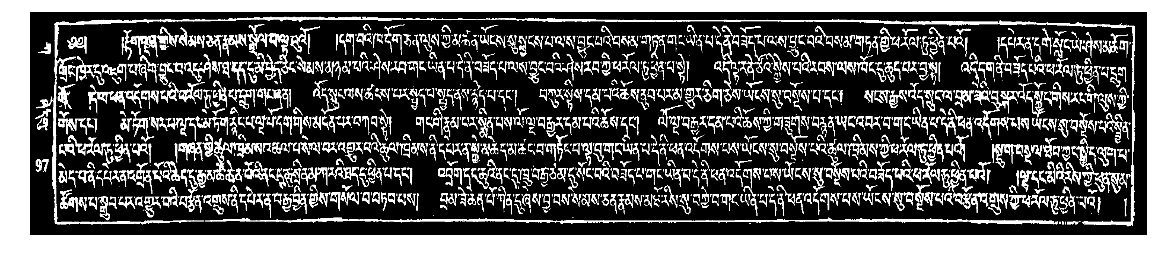

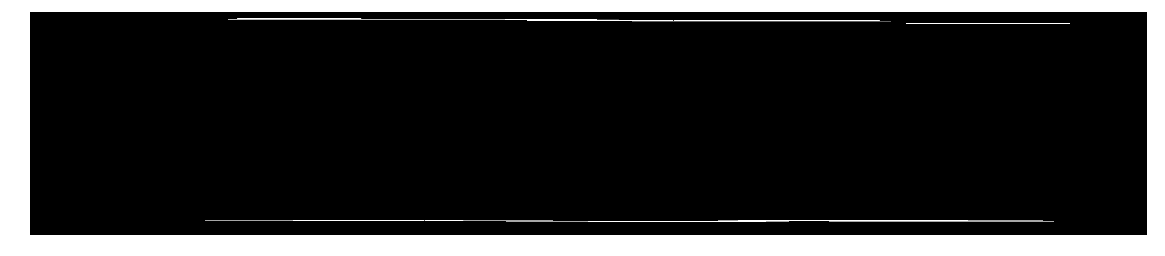

In [145]:
kernel = np.ones((1, 300), np.uint8)
opening_h = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
plot(thresh, cmap='gray')
plot(opening_h, cmap='gray');

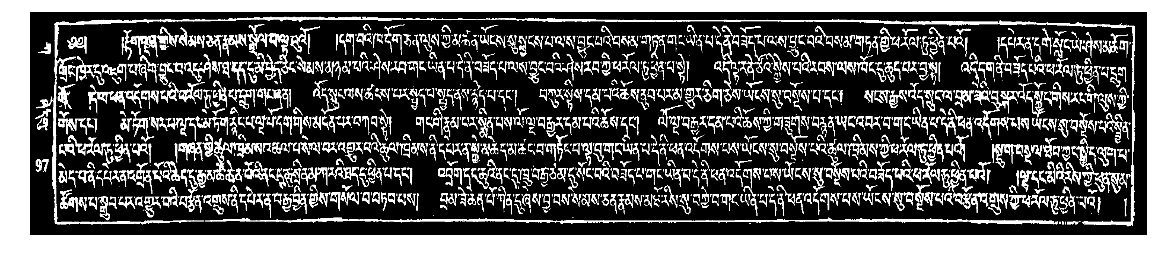

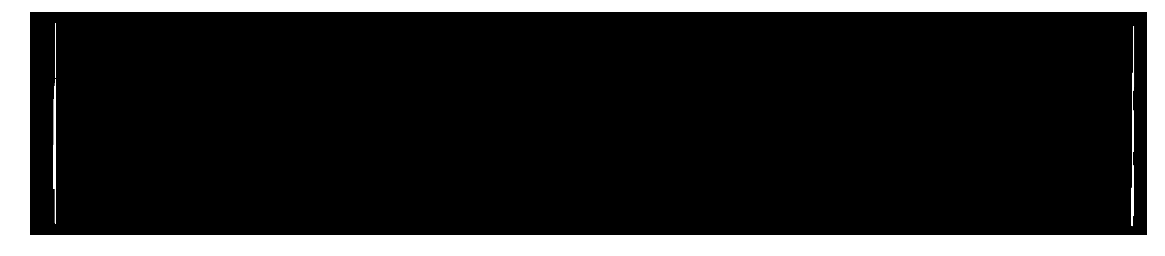

In [148]:
kernel = np.ones((100, 1), np.uint8)
opening_v = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
plot(thresh, cmap='gray')
plot(opening_v, cmap='gray');

Combine horizontal and vertical border

Estimate border box

In [ ]:
ret,thresh2 = cv2.threshold(dilation,127,255,cv2.THRESH_BINARY)
plot(thresh2, cmap='gray')

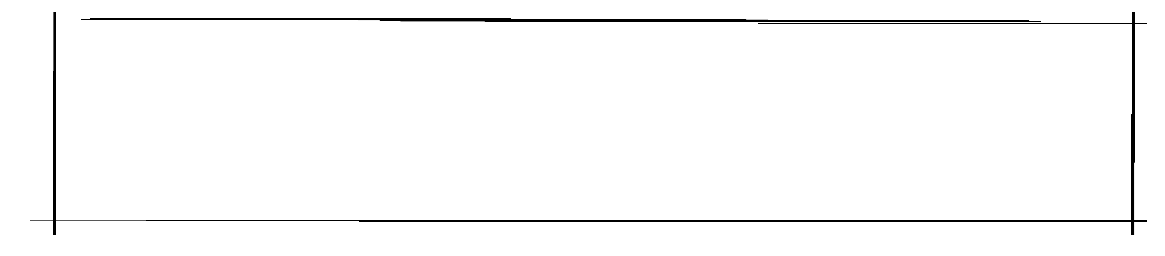

In [154]:
gray = cv2.bilateralFilter(thresh2, 11, 17, 17)
plot(gray, cmap='gray')

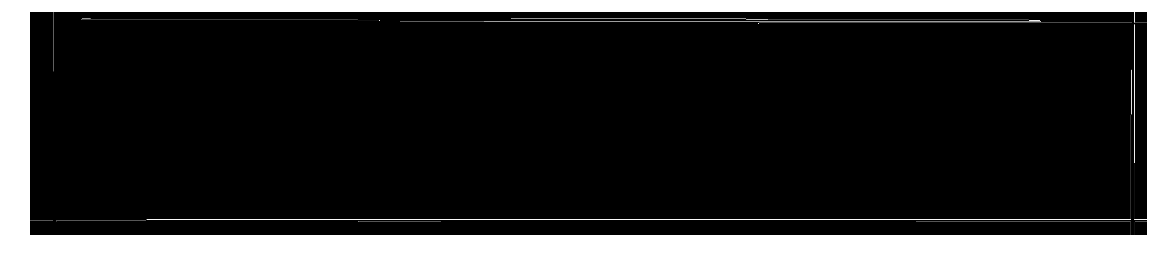

In [155]:
edged = cv2.Canny(gray, 10, 100)
plot(edged, cmap='gray')

In [156]:
edged.shape

(600, 3000)

houg line transformation

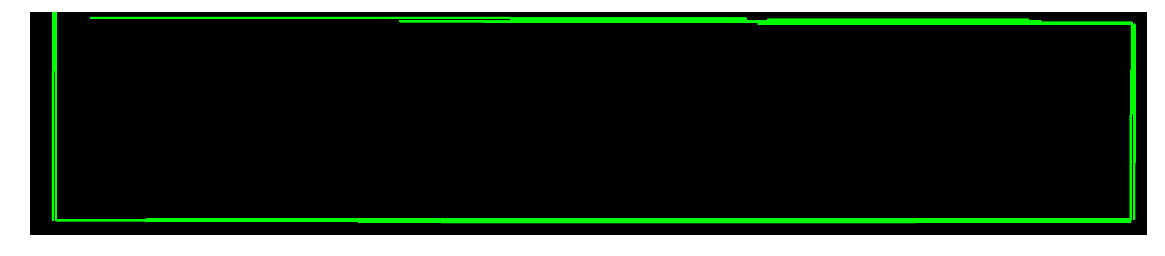

In [159]:
canvas = np.zeros(img.shape, np.uint8)

minLineLength = 1000
maxLineGap = 100
lines = cv2.HoughLinesP(edged.copy(),1,np.pi/180,100,minLineLength,maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(canvas,(x1,y1),(x2,y2),(0,255,0), 5)

plot(canvas, cmap='gray')

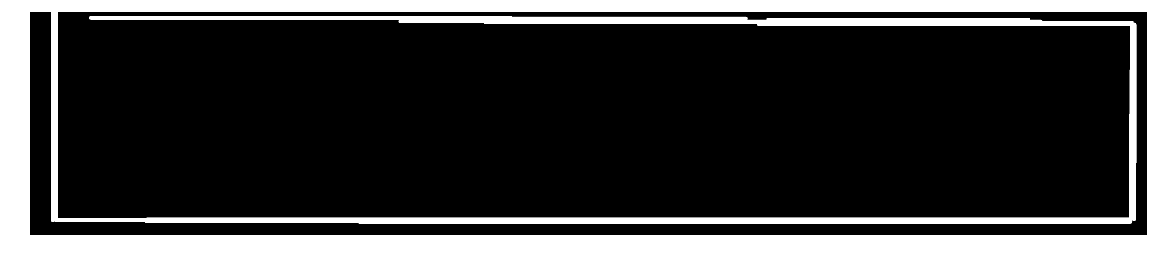

In [158]:
gray = cv2.cvtColor(canvas,cv2.COLOR_BGR2GRAY)
plot(gray, cmap='gray')

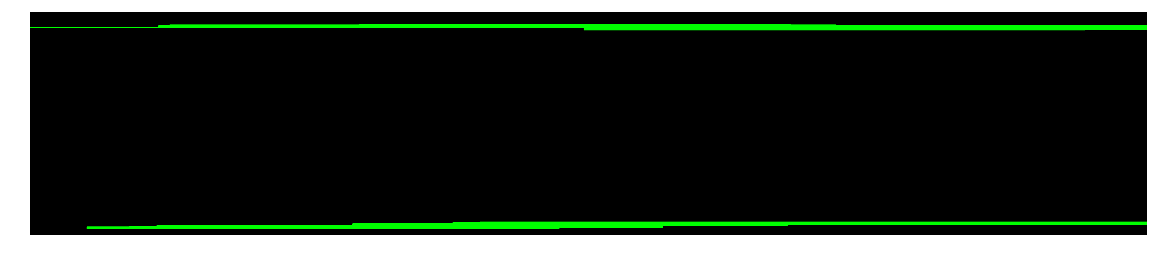

In [57]:
if len(canvas):
    del canvas
canvas = np.zeros(img.shape, np.uint8)

minLineLength = 100
maxLineGap = 1000
lines = cv2.HoughLinesP(gray,1,np.pi/180,100,minLineLength,maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(canvas,(x1,y1),(x2,y2),(0,255,0),2)
plot(canvas)

In [97]:
#img_test = cv2.imread('../images/page-006.png')
img_test = cv2.imread('../images/test1.png')
img_test = cv2.resize(img, (3000, 600))

mask = np.zeros(img.shape, np.uint8)

#cnts= cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

cnts= cv2.findContours(canvas, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# find the main island (biggest area)
#cnt = contours[0]
#max_area = cv2.contourArea(cnt)

#for cont in contours:
#    if cv2.contourArea(cont) > max_area:
#        cnt = cont
#        max_area = cv2.contourArea(cont)

# define main island contour approx. and hull
#perimeter = cv2.arcLength(cnt,True)
#epsilon = 0.01*cv2.arcLength(cnt,True)
#approx = cv2.approxPolyDP(cnt,epsilon,True)

cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
textCnt = None

# # loop over our contours
# for c in cnts:
#     # approximate the contour
#     peri = cv2.arcLength(c, True)
#     approx = cv2.approxPolyDP(c, 0.01 * peri, True)

#     # if our approximated contour has four points, then
#     # we can assume that we have found our screen
#     if len(approx) == 4:
#         textCnt = approx
#         break

# Approx the max contour
cnt = cnts[0]
peri = cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, 0.01 * peri, True)
textCnt = approx

# Draw the contours
#cv2.drawContours(img_test, [textCnt], 0, (0, 255, 0), 3);
cv2.drawContours(img_test, cnts, 0, (255, 255, 255), 10);
#cv2.drawContours(img, [approx], -1, (0, 0, 255), 3);

#cv2.drawContours(mask, [textCnt], 0, (0, 255, 0), 3);
cv2.drawContours(mask, cnts, 0, (255, 255, 255), 10);
#cv2.drawContours(canvas, [approx], -1, (0, 0, 255), 3);

error: OpenCV(3.4.1) /io/opencv/modules/imgproc/src/contours.cpp:199: error: (-210) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function cvStartFindContours_Impl


In [86]:
len(textCnt)

2

plot the approximated polygon point

In [87]:
# mask = np.zeros(img.shape, np.uint8)
# for p in textCnt:
#     cv2.circle(mask, (p[0][0], p[0][1]), 10, (0, 255, 0), -1)
# plot(mask)

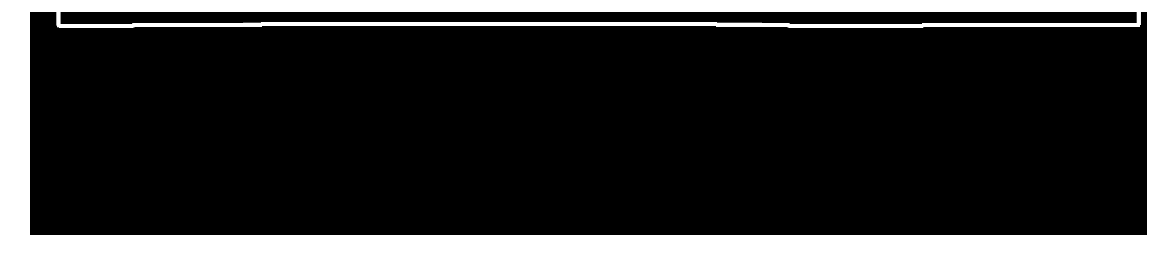

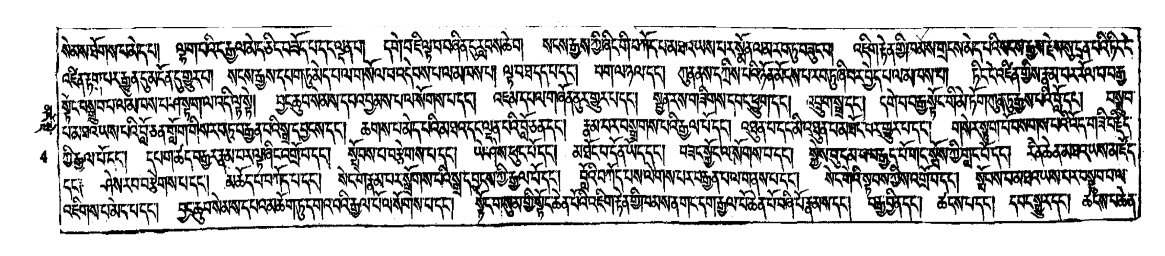

In [88]:
plot(mask)
plot(img_test)

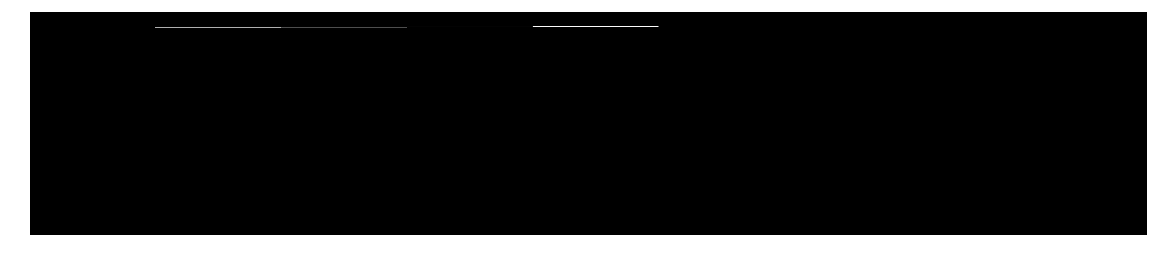

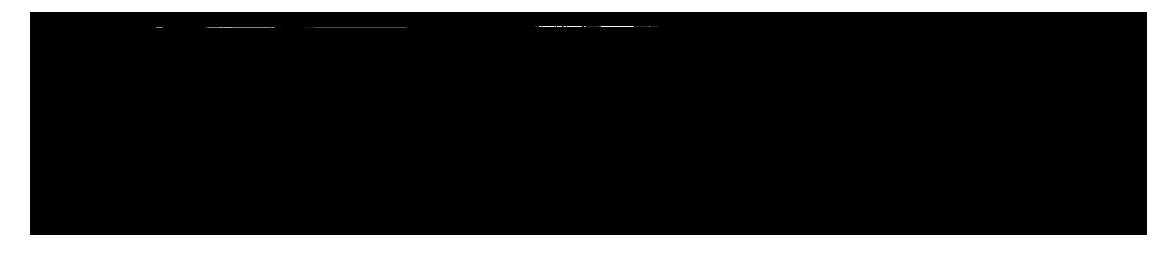

In [64]:
mask = np.zeros(img.shape, np.uint8)
roi_corners = np.array([[o[0] for o in textCnt]]); roi_corners
ignore_mask_color = (255, 255, 255)
cv2.fillPoly(mask, roi_corners, ignore_mask_color)
plot(mask)

# apply the mask to forground
fg_masked = cv2.bitwise_and(img, mask)

plot(fg_masked)

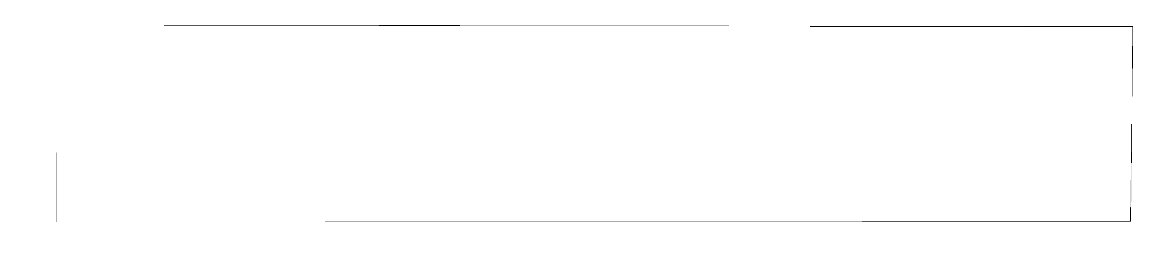

In [241]:
# get masked background, mask must be inverted 
bk = np.ones(img.shape, np.uint8) * 255
mask = cv2.bitwise_not(mask)
bk_masked = cv2.bitwise_and(bk, mask)

plot(bk_masked)

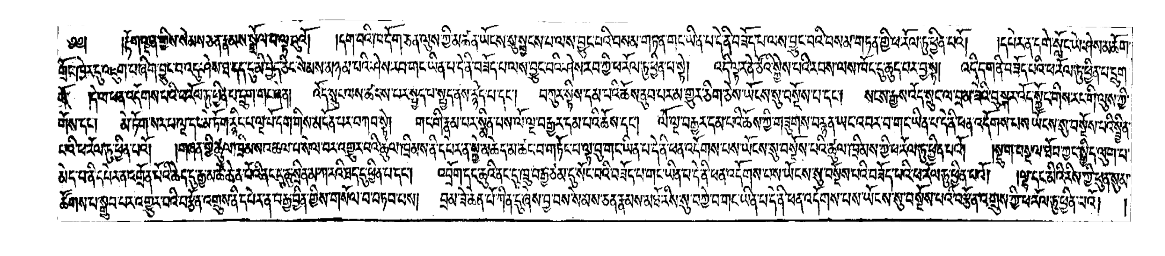

In [281]:
# combine masked foreground and masked background 
final = cv2.bitwise_or(fg_masked, bk_masked)

plot(final)

### 4. Closing
- Closing is reverse of Opening, Dilation followed by Erosion
- It is useful in closing small holes inside the foreground objects, or small black points on the object. 

Closing to recontruct the text

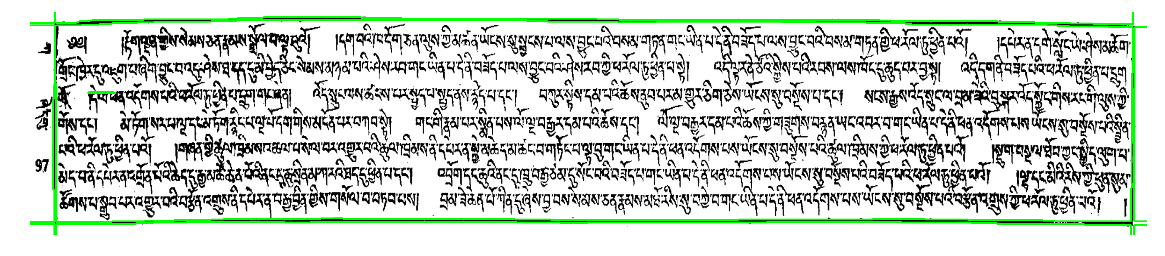

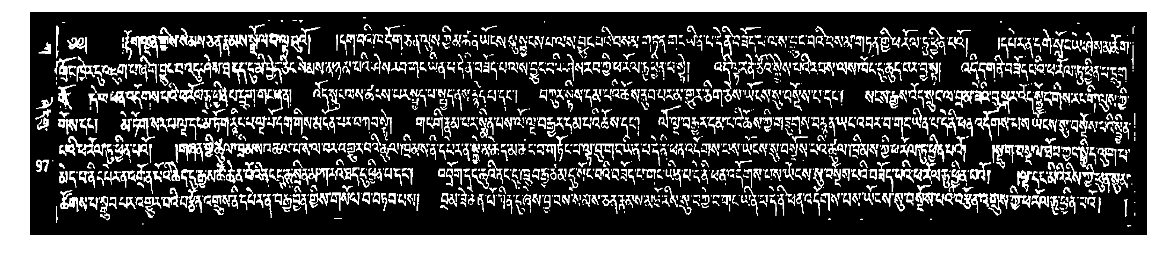

In [155]:
kernel = np.ones((2, 2), np.uint8)
final_1 = cv2.morphologyEx(output, cv2.MORPH_CLOSE, kernel)
plot(img)
plot(final_1, cmap='gray')

Inverse the image and save

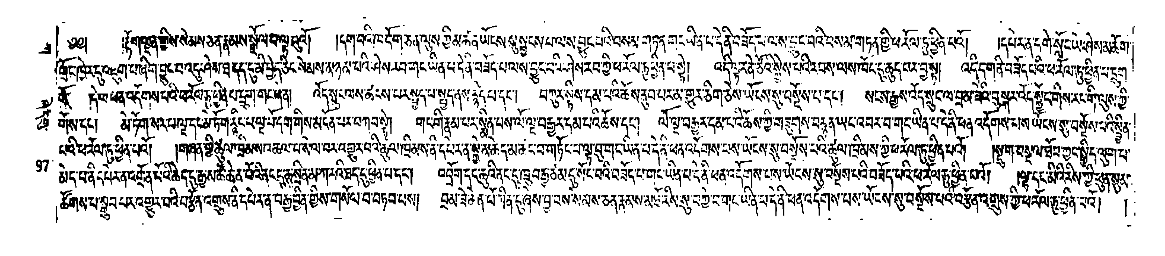

In [158]:
image = cv2.bitwise_not(final_1)
plot
plot(image, cmap='gray')

### 5. Morphological Gradient
- It is the difference between dilation and erosion of an image.
- The result will look like the outline of the object. 

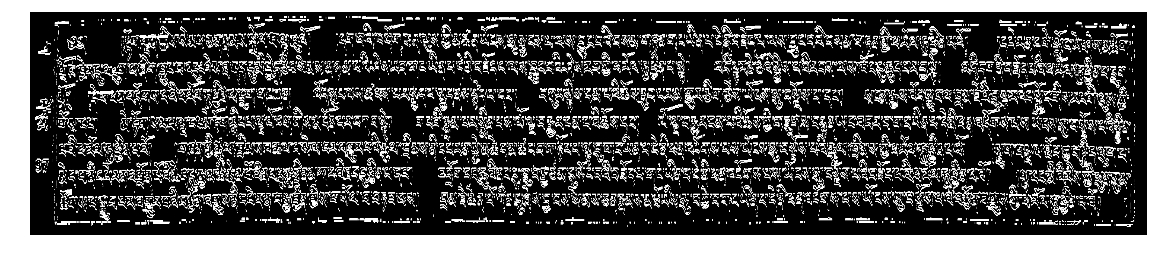

In [133]:
kernel = np.ones((5, 1), np.uint8)
gradient = cv2.morphologyEx(thresh, cv2.MORPH_GRADIENT, kernel)
plot(gradient, cmap='gray')

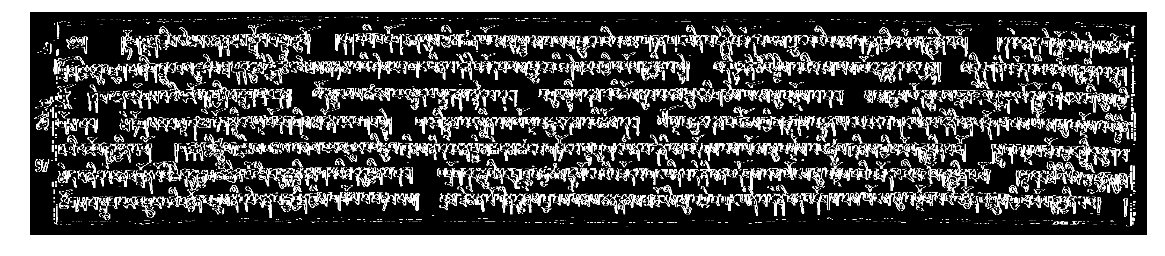

In [134]:
kernel = np.ones((1, 5), np.uint8)
gradient = cv2.morphologyEx(thresh, cv2.MORPH_GRADIENT, kernel)
plot(gradient, cmap='gray')

### 6. Top Hat 
- It is the difference between input image and Opening of the image.

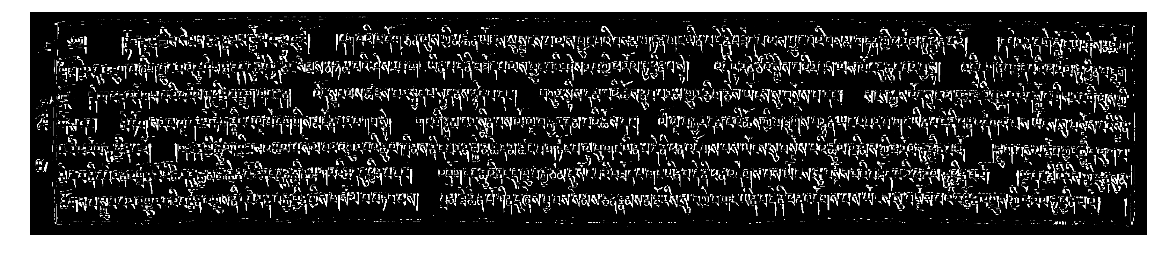

In [135]:
kernel = np.ones((1, 10), np.uint8)
tophat = cv2.morphologyEx(thresh, cv2.MORPH_TOPHAT, kernel)
plot(tophat, cmap='gray')

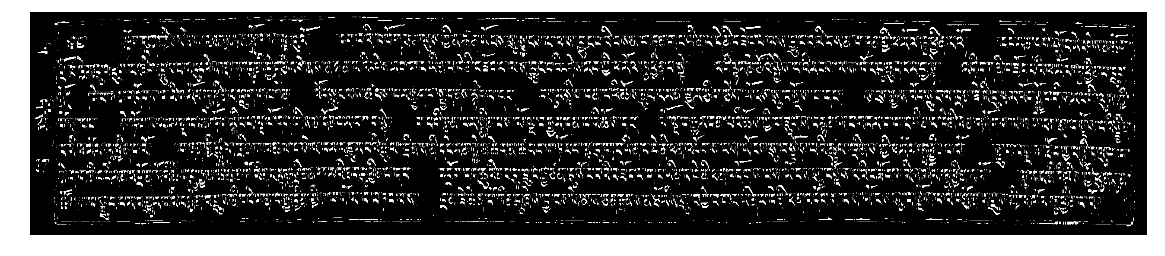

In [136]:
kernel = np.ones((10, 1), np.uint8)
tophat = cv2.morphologyEx(thresh, cv2.MORPH_TOPHAT, kernel)
plot(tophat, cmap='gray')

### 7. Black Hat
- It is the difference between the closing of the input image and input image.

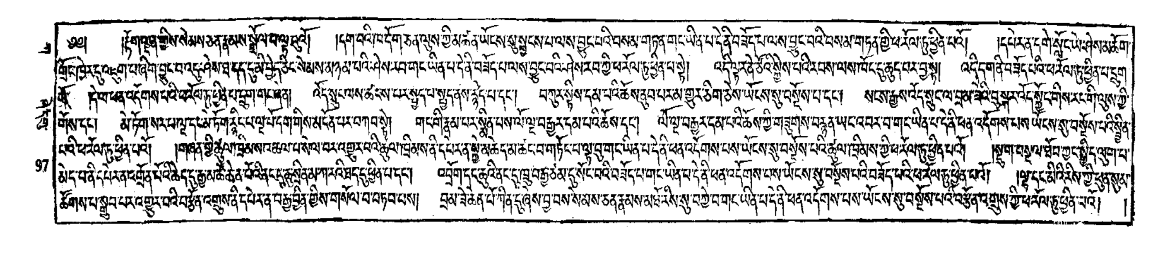

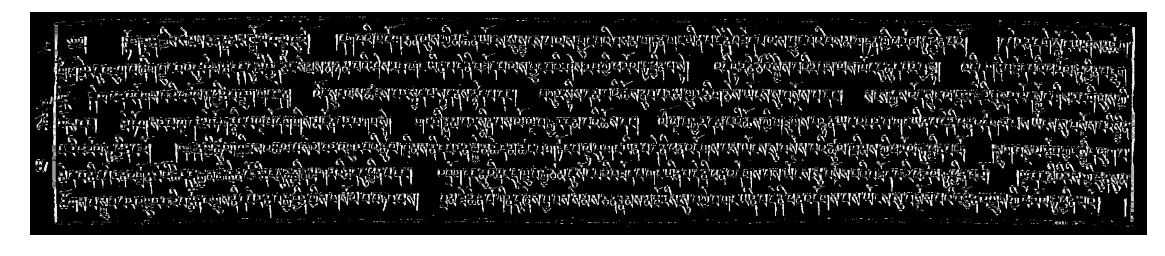

In [138]:
kernel = np.ones((1, 10), np.uint8)
blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
plot(img)
plot(blackhat)

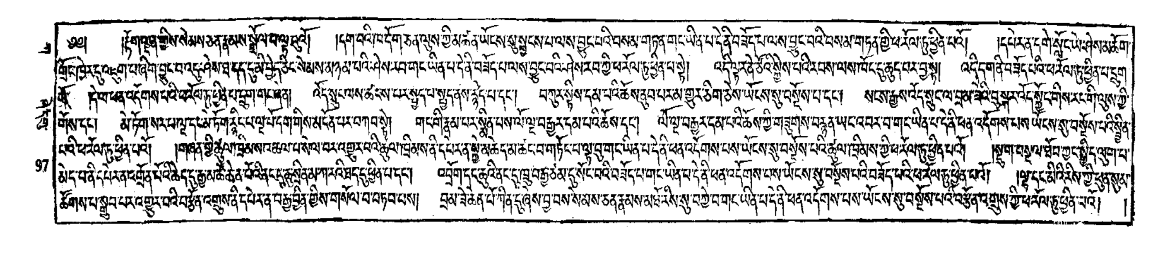

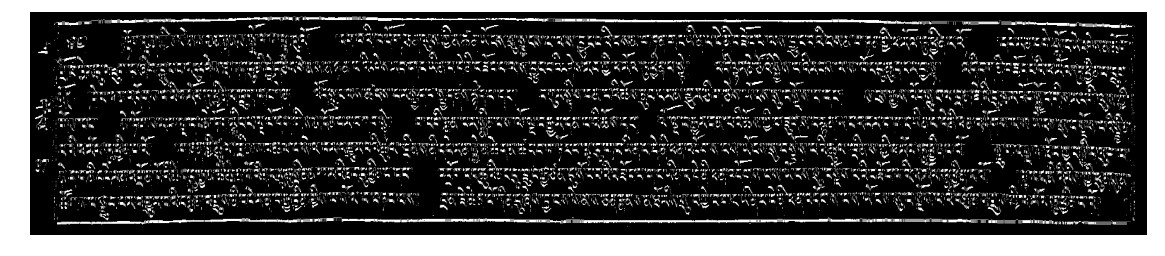

In [139]:
kernel = np.ones((10, 1), np.uint8)
blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
plot(img)
plot(blackhat)